# <p style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Customers Segmentation <br> (K-Means, SVM)</p>

 <p style="display: inline-block; padding: 7px; background-color: #fef0e9; color: #AF4343; text-decoration: none; border-radius: 5px 5px; font-size: 150%; text-align: center; border: 1px solid #AF4343; font-family: 'New Times Roman', serif;">-  Table of contents         -</p>
    
    
[1. Library import & Dataset](#1) 

[2. Data cleaning](#2)
      
[3. Clustering](#3)
    
[4. Visualization Clusters](#4)

[5. Classification Model](#5) 
     
[6. Prediction New Customer](#6)
    

# <p id="1" style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Library import & Dataset</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

import datetime
import plotly.express as px 
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [2]:
palette = ["#a7e149","#e149a7", "#c393f4", "#d683f2", "#dd9e9e", "#fa91aa", "#fc9e9e", "#49e183", "#aa91aa", "#ff93f4"]

In [3]:
# Set a custom value for the maximum number of columns to be displayed
pd.options.display.max_columns = None

In [4]:
data = pd.read_csv('marketing_campaign.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [6]:
def outlier_thresholds(df, var):
    q1 = df[var].quantile(0.01)
    q3 = df[var].quantile(0.75)
    interquantile_range = q3 - q1
    up_limit = q3 + 1.5*interquantile_range
    low_limit = q1 - 1.5*interquantile_range
    return low_limit, up_limit

def summary(df):
    #Missing value information
    missing_info = pd.DataFrame(df.isnull().sum(), columns =['Missing Values'] )
    # Data type
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary_df = pd.concat([missing_info, data_types], axis = 1)
    
    # Iterate through each column in your DataFrame
    for column in df.columns:    
        # Check if the column is categorical
        if pd.api.types.is_object_dtype(df[column]):
            num_unique_choices = df[column].nunique()
            # Add the number of unique choices to the summary DataFrame
            summary_df.loc[column, 'Unique Choices'] = num_unique_choices
            
        if pd.api.types.is_numeric_dtype(df[column]):
            # Get the lower and upper thresholds for outliers
            low_limit, up_limit = outlier_thresholds(df, column) 
            
            # Calculate the range (max - min) for numeric columns
            summary_df.loc[column, 'min'] = df[column].min()
            # Calculate the range (max - min) for numeric columns
            summary_df.loc[column, 'max'] = df[column].max()            
            summary_df.loc[column, 'Mean'] = df[column].mean()
            # Calculate the median (50% percentile)
            summary_df.loc[column, 'Median'] = df[column].median()
            # Calculate the variance
            summary_df.loc[column, 'Variance'] = df[column].var()
            # Calculate the standard deviation
            summary_df.loc[column, 'deviation'] = df[column].std()

            
            # Count the number of outliers in the column
            num_outliers = len(df[(df[column] < low_limit) | (df[column] > up_limit)])    
            # Add the outlier count to the summary DataFrame
            summary_df.loc[column, 'Num Outliers'] = num_outliers
        

    return summary_df

summary(data)

Missing Values Data Type     min       max          Mean  \
ID                                0     int64     0.0   11191.0   5592.159821   
Year_Birth                        0     int64  1893.0    1996.0   1968.805804   
Education                         0    object     NaN       NaN           NaN   
Marital_Status                    0    object     NaN       NaN           NaN   
Income                           24   float64  1730.0  666666.0  52247.251354   
Kidhome                           0     int64     0.0       2.0      0.444196   
Teenhome                          0     int64     0.0       2.0      0.506250   
Dt_Customer                       0    object     NaN       NaN           NaN   
Recency                           0     int64     0.0      99.0     49.109375   
MntWines                          0     int64     0.0    1493.0    303.935714   
MntFruits                         0     int64     0.0     199.0     26.302232   
MntMeatProducts                   0     int64     0.0    1725.0    166.950000   
MntFishProducts                   0     int64     0.0     259.0     37.525446   
MntSweetProducts                  0     int64     0.0     263.0     27.062946   
MntGoldProds                      0     int64     0.0     362.0     44.021875   
NumDealsPurchases                 0     int64     0.0      15.0      2.325000   
NumWebPurchases                   0     int64     0.0      27.0      4.084821   
NumCatalogPurchases               0     int64     0.0      28.0      2.662054   
NumStorePurchases                 0     int64     0.0      13.0      5.790179   
NumWebVisitsMonth                 0     int64     0.0      20.0      5.316518   
AcceptedCmp3                      0     int64     0.0       1.0      0.072768   
AcceptedCmp4                      0     int64     0.0       1.0      0.074554   
AcceptedCmp5                      0     int64     0.0       1.0      0.072768   
AcceptedCmp1                      0     int64     0.0       1.0      0.064286   
AcceptedCmp2                      0     int64     0.0       1.0      0.013393   
Complain                          0     int64     0.0       1.0      0.009375   
Z_CostContact                     0     int64     3.0       3.0      3.000000   
Z_Revenue                         0     int64    11.0      11.0     11.000000   
Response                          0     int64     0.0       1.0      0.149107   

                      Median      Variance     deviation  Num Outliers  \
ID                    5458.5  1.054082e+07   3246.662198           0.0   
Year_Birth            1970.0  1.436179e+02     11.984069           1.0   
Education                NaN           NaN           NaN           NaN   
Marital_Status           NaN           NaN           NaN           NaN   
Income               51381.5  6.336838e+08  25173.076661           3.0   
Kidhome                  0.0  2.898725e-01      0.538398           0.0   
Teenhome                 0.0  2.965219e-01      0.544538           0.0   
Dt_Customer              NaN           NaN           NaN           NaN   
Recency                 49.0  8.388237e+02     28.962453           0.0   
MntWines               173.5  1.132978e+05    336.597393          27.0   
MntFruits                8.0  1.581926e+03     39.773434         225.0   
MntMeatProducts         67.0  5.094743e+04    225.715373         157.0   
MntFishProducts         12.0  2.984325e+03     54.628979         210.0   
MntSweetProducts         8.0  1.704080e+03     41.280498         244.0   
MntGoldProds            24.0  2.721442e+03     52.167439         171.0   
NumDealsPurchases        2.0  3.733542e+00      1.932238          46.0   
NumWebPurchases          4.0  7.721252e+00      2.778714           4.0   
NumCatalogPurchases      2.0  8.544517e+00      2.923101          23.0   
NumStorePurchases        5.0  1.056873e+01      3.250958           0.0   
NumWebVisitsMonth        6.0  5.888606e+00      2.426645           6.0   
AcceptedCmp3             0.0  6.7502

In [7]:
print("Values of column 'Marital_Status' are:\n", data["Marital_Status"].unique())
print('')
print("Values of column 'Education' are:\n",data["Education"].unique())

Values of column 'Marital_Status' are:
 ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

Values of column 'Education' are:
 ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


<div style="border-radius:10px;border:#c3d2bd solid;padding:15px;background-color:#f3f8f1;font-size:110%;text-align:left">
    
 <p style="display: inline-block; padding: 7px; background-color: #d9ead3; color: #565d54; text-decoration: none; border-radius: 5px 5px; font-size: 150%; text-align: left; border: 1.5px solid #828c7e; font-family: 'New Times Roman', serif;">-  Notes    -</p>
    
**From the above output, we can conclude and note that:**

- There are missing and outliers values in **income**
- **Dt_Customer** that indicates the date a customer joined the database is not parsed as DateTime
- There are some categorical features in our data frame; as there are some features in dtype: object. So we will need to encode them into numeric forms later.

**Plan to manipulate with data:**
* Extract the **Age** of a customer by the **Year_Birth** indicating the birth year of the respective person.

* Create another feature **Monetary** indicating the total amount Monetary by the customer in various categories over the span of two years.

* Create a feature **Children** to indicate total children in a household that is, kids and teenagers.

* To get further clarity of household, Creating feature indicating **Family_Size**

* I will create others categories in the **Education** by simplifying its value counts.

* Dropping some of the redundant features

# <p id="3" style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Data cleaning </p>

In [8]:
#To remove the NA values
data = data.dropna()
len(data)

2216

In [9]:
#Dt_Customer to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format="%d-%m-%Y")


#Deriving living situation by marital status
data["Living_With"]=data["Marital_Status"].replace({
    "Married":"Partner","Together":"Partner","Absurd":"Alone","Widow":"Alone",
    "YOLO":"Alone","Divorced":"Alone","Single":"Alone",})

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", 
                                             "Graduation":"Graduate", "Master":"Postgraduate", 
                                             "PhD":"Postgraduate"})

#Age of customer today 
data["Age"] = 2020-data["Year_Birth"]

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#For clarity
data["Frequency"]=data["NumDealsPurchases"] + data["NumWebPurchases"] +  data["NumCatalogPurchases"] + data["NumStorePurchases"]

#Total spendings on various items
data["Monetary"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

In [10]:
df = data.copy()

In [11]:
#Dropping some of the redundant features
del_cols = ["Marital_Status", "Z_CostContact", "Z_Revenue", 
            'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response',
           "MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds",
           "NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases", 'NumWebVisitsMonth',
           "Year_Birth", "Kidhome","Teenhome"] 
data =  data.drop(del_cols, axis=1)

In [12]:
numeric_columns = data.select_dtypes(include=['number']).columns

def outliers_boxplots(df, columns=numeric_columns, title="Outlier <i>Numeric Columns</i>", color="crimson"):
    fig = make_subplots(rows=1, cols=len(columns), subplot_titles=columns)
    for i, column in enumerate(columns):
        trace = go.Box(y=df[column], name=f'{column}', marker=dict(color=color))
        fig.add_trace(trace, row=1, col=i+1)
    fig.update_layout(title_text=title, title_x=0.5)

    fig.show()
    
outliers_boxplots(data, numeric_columns)

In [13]:
data = data[data.Income < 100000]
data = data[data.Age < 80]
data = data[data.Monetary < 1200]
data = data[data.Frequency < 40]

In [14]:
outliers_boxplots(data, numeric_columns)

In [15]:
summary(data)

Missing Values       Data Type     min      max          Mean  \
ID                        0           int64     0.0  11191.0   5582.380235   
Education                 0          object     NaN      NaN           NaN   
Income                    0         float64  1730.0  96547.0  45846.597432   
Dt_Customer               0  datetime64[ns]     NaN      NaN           NaN   
Recency                   0           int64     0.0     99.0     48.652150   
Living_With               0          object     NaN      NaN           NaN   
Age                       0           int64    24.0     77.0     50.918481   
Children                  0           int64     0.0      3.0      1.100503   
Family_Size               0           int64     1.0      5.0      2.753769   
Frequency                 0           int64     0.0     39.0     13.321608   
Monetary                  0           int64     5.0   1199.0    376.259631   

              Median      Variance     deviation  Num Outliers  Unique Choices  
ID            5462.0  1.078608e+07   3284.216582           0.0             NaN  
Education        NaN           NaN           NaN           NaN             3.0  
Income       44964.0  3.251474e+08  18031.844486           0.0             NaN  
Dt_Customer      NaN           NaN           NaN           NaN             NaN  
Recency         49.0  8.355264e+02     28.905474           0.0             NaN  
Living_With      NaN           NaN           NaN           NaN             2.0  
Age             50.0  1.295554e+02     11.382239           0.0             NaN  
Children         1.0  5.005081e-01      0.707466           0.0             NaN  
Family_Size      3.0  7.454816e-01      0.863413           0.0             NaN  
Frequency       12.0  5.352333e+01      7.315964           0.0             NaN  
Monetary       211.0  1.404030e+05    374.703874           0.0             NaN

# <p id="4" style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Dimensionality Reduction and Clustering </p>

In [16]:
import scipy.stats as stats
# Create a contingency table
contingency_table = pd.crosstab(data['Education'], data['Living_With'])

# Perform a chi-square test
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Display the p-value and chi-squared statistic
print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

# Create a Plotly bar chart
fig = px.bar(contingency_table,
             x=contingency_table.index,
             y=contingency_table.columns,
             title=f'Chi-Square Test: P-value = {p:.4f}',
             labels={'x': 'Education', 'y': 'Living_With'},
             barmode='group')

# Show the plot
fig.show()

Chi-squared statistic: 2.011318828947375
P-value: 0.3658033392394474


In my case, since the **Chi-squared** statistic of 2.011 ,and **p-value** is 0.364 > 0.05, it indicates that there is not enough evidence to reject the null hypothesis, suggesting that the variables "Education" and "Living_With" are not significantly associated in your data. 

In [17]:
#Get list of categorical variables
LE=LabelEncoder()
object_cols =["Education","Living_With"]
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
print('All features are now numerical')
data.head()

All features are now numerical


ID  Education   Income Dt_Customer  Recency  Living_With  Age  Children  \
1  2174          0  46344.0  2014-03-08       38            0   66         2   
2  4141          0  71613.0  2013-08-21       26            1   55         0   
3  6182          0  26646.0  2014-02-10       26            1   36         1   
4  5324          1  58293.0  2014-01-19       94            1   39         1   
5  7446          1  62513.0  2013-09-09       16            1   53         1   

   Family_Size  Frequency  Monetary  
1            3          6        27  
2            2         21       776  
3            3          8        53  
4            3         19       422  
5            3         22       716

In [18]:
data_clustering=data[["Education","Income","Age", "Recency","Family_Size","Monetary","Frequency"]]
#Scaling
scaler = StandardScaler()
scaler.fit(data_clustering)
scaled_features = pd.DataFrame(scaler.transform(data_clustering),columns= data_clustering.columns )
print('All features are now scalled')
scaled_features.head()

All features are now scalled


Education    Income       Age   Recency  Family_Size  Monetary  Frequency
0  -0.891976  0.027592  1.325375 -0.368620     0.285263 -0.932355  -1.001051
1  -0.891976  1.429338  0.358687 -0.783882    -0.873255  1.067115   1.049832
2  -0.891976 -1.065113 -1.311047 -0.783882     0.285263 -0.862948  -0.727600
3   0.543360  0.690438 -1.047405  1.569271     0.285263  0.122105   0.776381
4   0.543360  0.924534  0.182925 -1.129934     0.285263  0.906944   1.186558

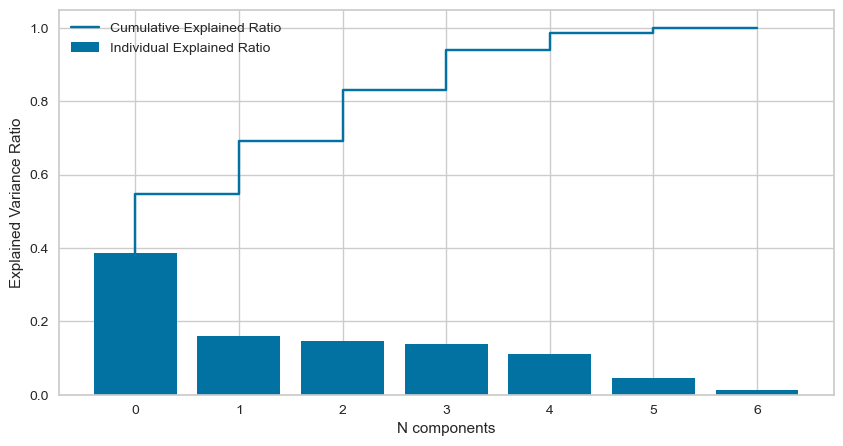

In [19]:
#PCA
pca = PCA()
pca.fit(scaled_features)
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio")
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

* The first 3 components have slightly more than 80% of the informations

In [20]:
cols = ["PCA1", "PCA2", "PCA3"]
pca = PCA(n_components=3)
pca.fit(scaled_features)
PCA_df = pd.DataFrame(pca.transform(scaled_features), columns=(cols))
PCA_df.describe().T

count          mean       std       min       25%       50%       75%  \
PCA1  1791.0  1.101855e-17  1.644252 -2.768638 -1.444655 -0.341976  1.507910   
PCA2  1791.0 -1.971250e-17  1.060736 -3.075979 -0.665775 -0.037431  0.724306   
PCA3  1791.0 -1.053813e-17  1.011464 -2.469239 -0.693173 -0.014278  0.714996   

           max  
PCA1  4.155794  
PCA2  3.136918  
PCA3  2.504693

### Elbow Method
* Use Elbow method to **determine** the optimal number of clusters in a dataset for algorithms like K-Means.
* It involves running the clustering algorithm with different numbers of clusters (e.g., 1 to K) and calculating the cost function (usually within-cluster sum of squares, or WCSS) for each value of K.

* As the number of clusters increases, the WCSS generally decreases, because more clusters mean that data points are closer to their cluster centers. However, adding more clusters eventually leads to diminishing returns. The Elbow Method looks for an "elbow" point in the plot of WCSS against the number of clusters. The elbow point is where the rate of decrease in WCSS sharply changes, and it indicates the optimal number of clusters.

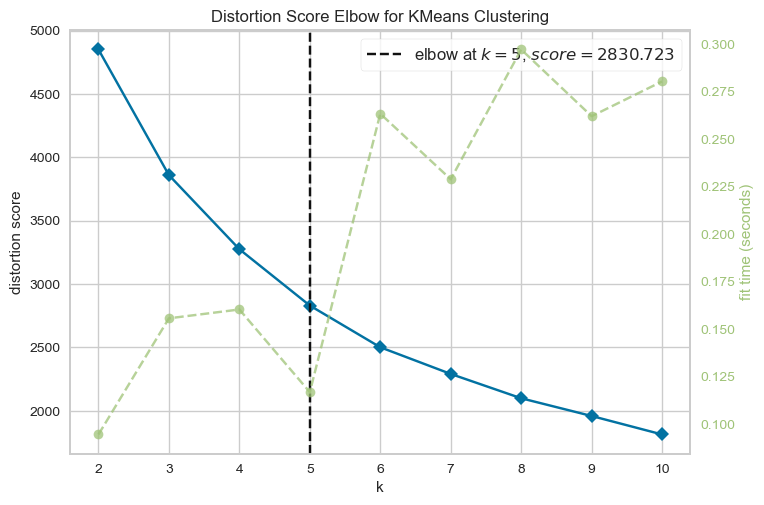

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()  

The above cell indicates that **4 will be an optimal number of clusters** for this data.

### Silhouette score
* The silhouette score is a metric used to measure the quality of clusters in unsupervised learning. It quantifies how similar each data point in one cluster is to other data points in the same cluster compared to the nearest neighboring cluster.

* The silhouette score helps evaluate the appropriateness of clustering solutions. Higher silhouette scores indicate better-defined clusters, helping to determine the optimal number of clusters in clustering algorithms like K-Means. RMF Metric (Recency, Frequency, Monetary)

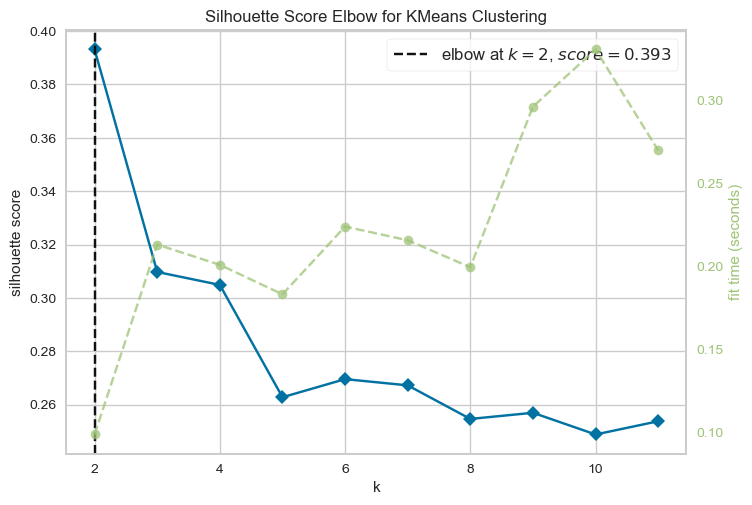

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [22]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11, metric='silhouette')
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show() 

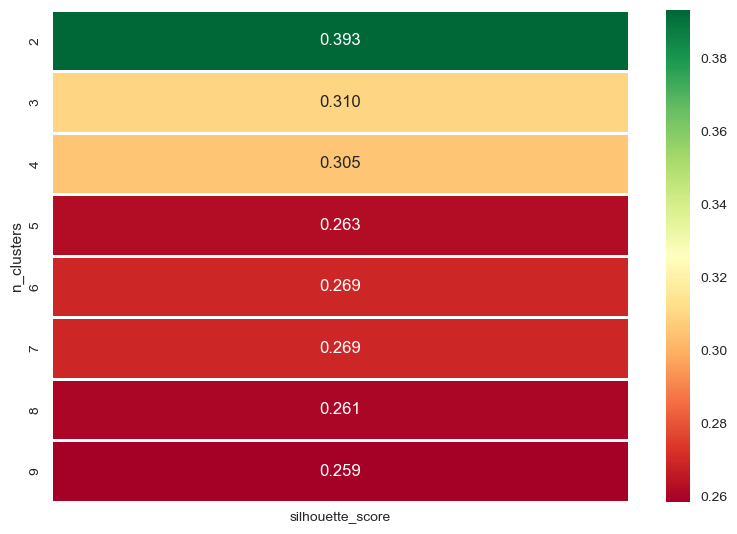

In [23]:
from sklearn.metrics import silhouette_score
def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.show()
    
visualize_silhouette_layer(PCA_df)

### Notes:

* The silhouette score measures the quality of clusters in your data, ranges from -1 to 1.

* Higher values indicate that the clusters are well-separated, with data points within the same cluster being more similar to each other than to data points in other clusters.
* Lower or negative values suggest that the clusters may be overlapping or incorrectly grouped.

**Per-Cluster Silhouette Scores**:

* Cluster 2 has an average silhouette score of 0.393, which suggests that it is well-separated and internally cohesive.
* Cluster 3 and 4 has an average silhouette score of 0.31 and 0.305, indicating a reasonably good separation.
* Cluster 5 and Cluster 6 have lower silhouette scores (0.263 and 0.269), but they are still relatively well-separated.

--> **We can go ahead with 4 clusters**

In [25]:
#Initiating the Agglomerative Clustering model 
KM = KMeans(n_clusters=4, random_state = 42)
# fit model and predict clusters
KM_df = KM.fit_predict(PCA_df)
PCA_df["Clusters"] = KM_df
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= KM_df

# <p id="1" style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Visualization Clusters</p>

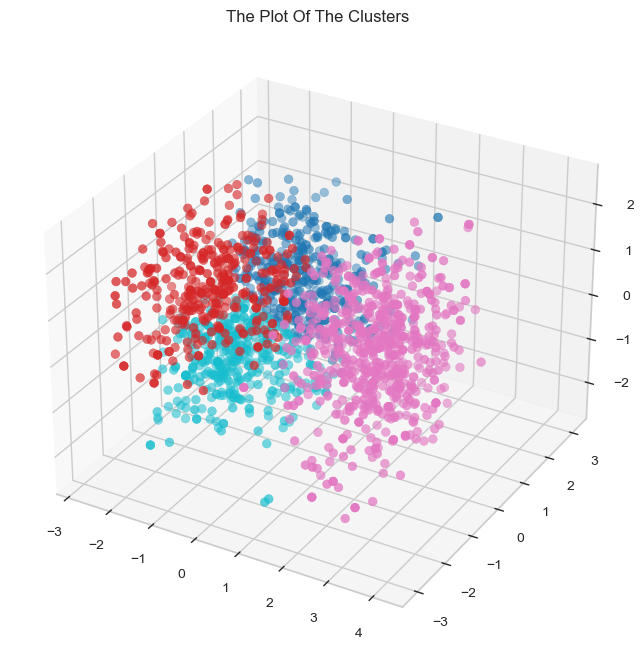

In [26]:
x =PCA_df["PCA1"]
y =PCA_df["PCA2"]
z =PCA_df["PCA3"]
c =PCA_df["Clusters"]
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=c, marker='o', cmap = 'tab10')
ax.set_title("The Plot Of The Clusters")
plt.show()

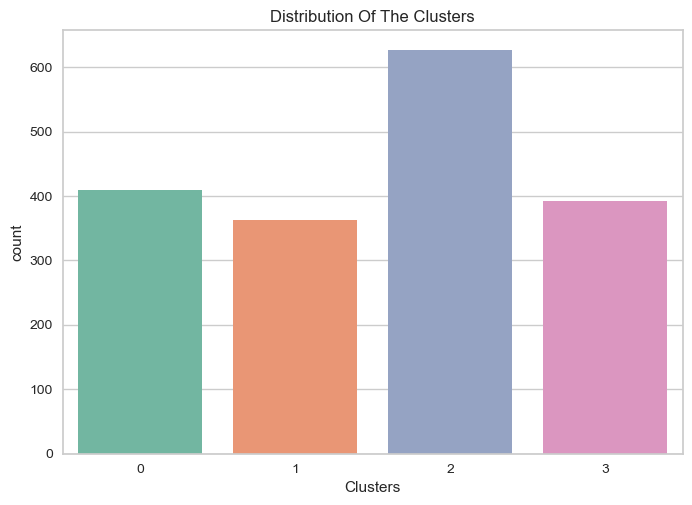

In [27]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters"], palette= "Set2")
pl.set_title("Distribution Of The Clusters")
plt.show()

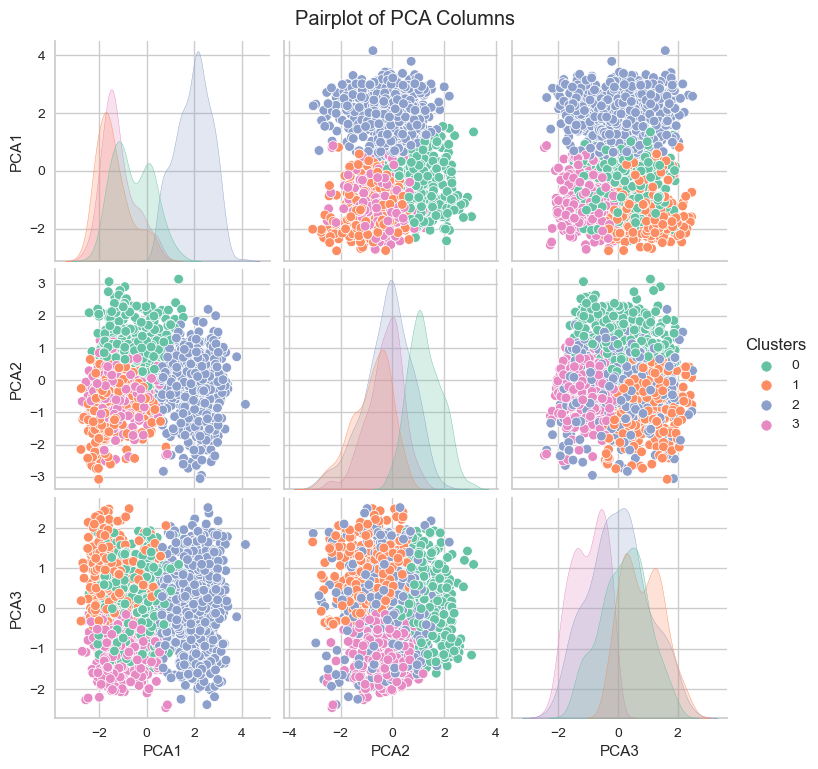

In [28]:
# Create a pairplot for all combinations of PCA columns
sns.pairplot(data=PCA_df, vars=['PCA1', 'PCA2', 'PCA3'], hue='Clusters', palette="Set2")
plt.suptitle("Pairplot of PCA Columns", y=1.02)
plt.show()

In [29]:
data.head()

ID  Education   Income Dt_Customer  Recency  Living_With  Age  Children  \
1  2174          0  46344.0  2014-03-08       38            0   66         2   
2  4141          0  71613.0  2013-08-21       26            1   55         0   
3  6182          0  26646.0  2014-02-10       26            1   36         1   
4  5324          1  58293.0  2014-01-19       94            1   39         1   
5  7446          1  62513.0  2013-09-09       16            1   53         1   

   Family_Size  Frequency  Monetary  Clusters  
1            3          6        27         0  
2            2         21       776         2  
3            3          8        53         3  
4            3         19       422         2  
5            3         22       716         2

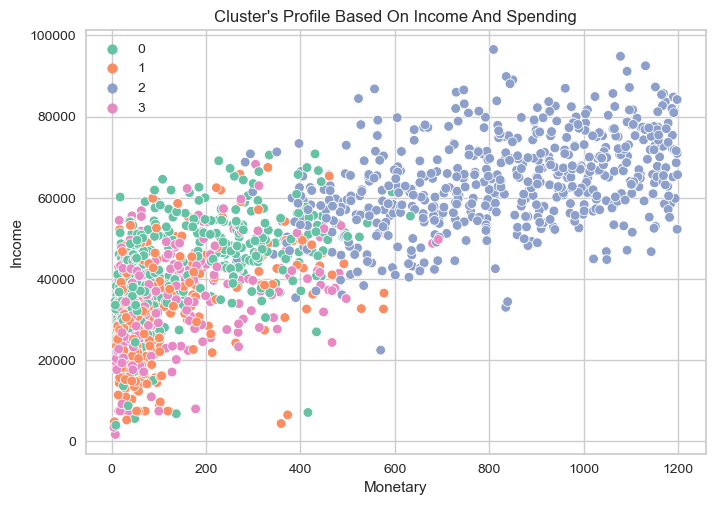

In [30]:
pl = sns.scatterplot(data=data, x=data["Monetary"], y=data["Income"], hue=data["Clusters"],
                     palette="Set2")
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

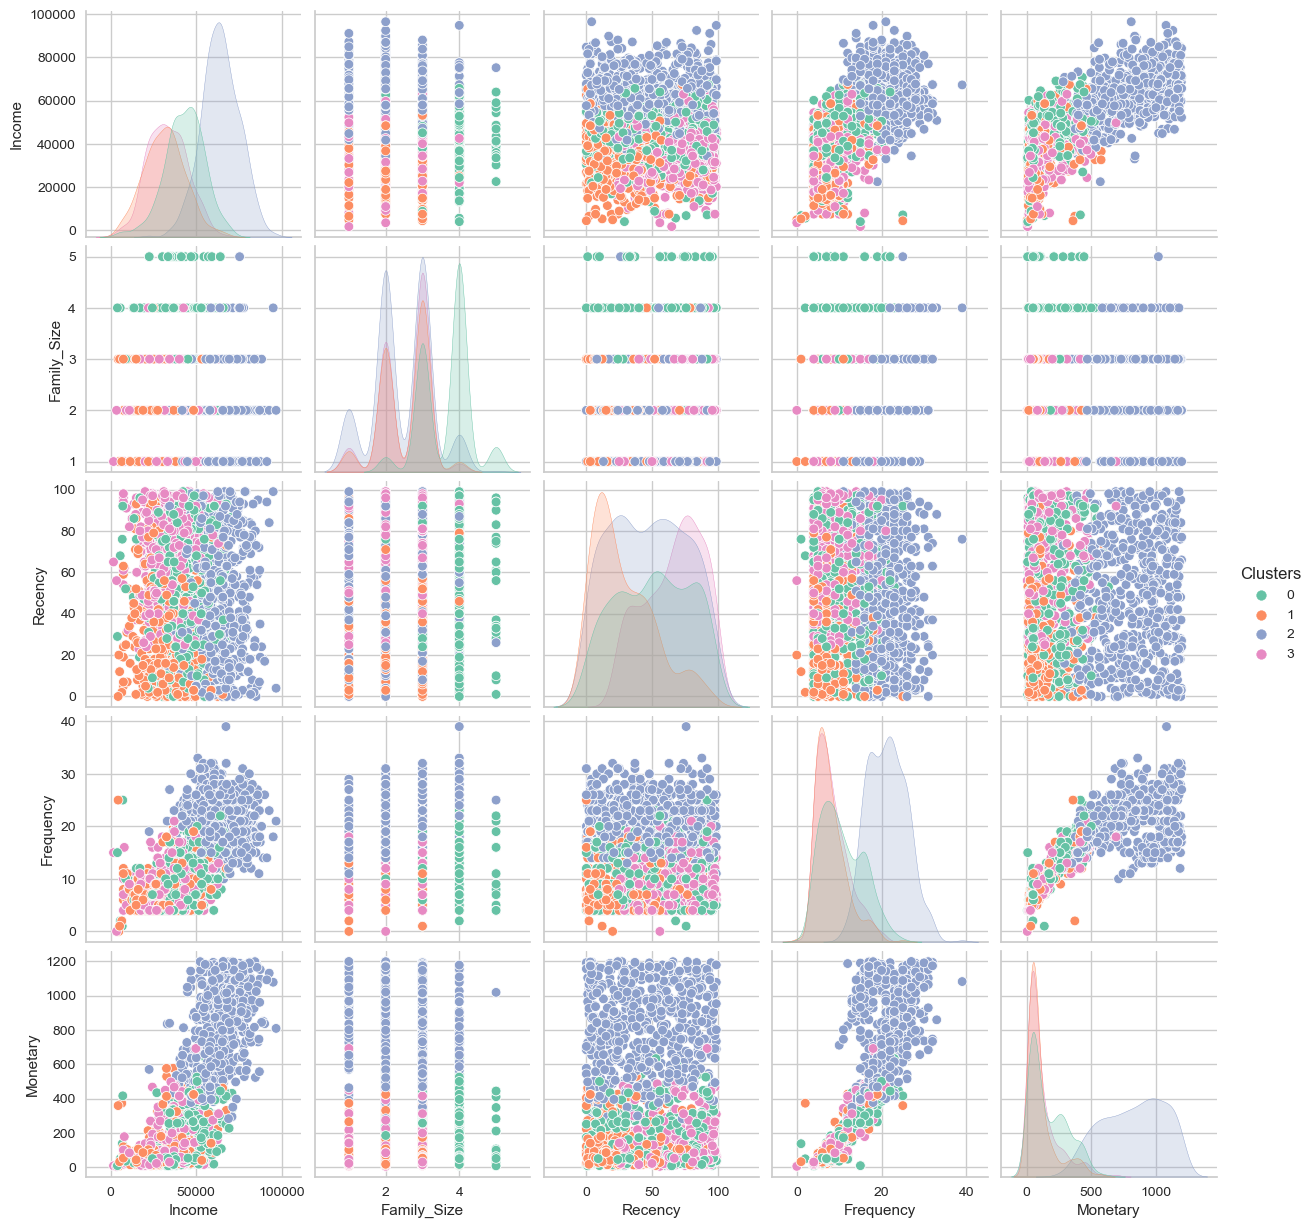

In [31]:
sns.pairplot(data[["Clusters","Income","Family_Size","Recency", "Frequency", "Monetary"]],hue= "Clusters",palette= "Set2")
#Taking hue 
plt.show()

In [32]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

columns = ["Income", "Age", "Family_Size", "Recency", "Frequency", "Monetary"]

# Create a subplot grid
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Clusters vs. {column}' for column in columns], horizontal_spacing=0.15)

for i, column in enumerate(columns):
    row = i // 3 + 1
    col = i % 3 + 1
    
    # Create a box plot for each column
    trace = go.Box(y=data[column], x=data["Clusters"], name=f'Clusters vs. {column}', )
    fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(
    showlegend=False,
    height=800,
    title_text="Clusters vs. Numeric Columns",
)

# Show the plot
fig.show()


In [33]:
means = data.groupby(['Clusters']).agg({'Family_Size': 'mean',
                                        "Living_With": 'mean',
                                        "Children":'mean',
                                        'Income': 'mean',
                                        'Age': 'mean',
                                        'Recency': 'mean',
                                        'Frequency': 'mean',
                                         'Monetary': 'mean'})
# Calculate the count of records (rows) in each cluster
counts = data['Clusters'].value_counts().reset_index()
counts.columns = ['Clusters', 'Count']

# Merge the mean and count DataFrames
result = pd.merge(means, counts, on='Clusters')
result

Clusters  Family_Size  Living_With  Children        Income        Age  \
0         0     3.646341     0.826829  1.819512  42995.109756  58.500000   
1         1     2.523416     0.603306  0.920110  31505.424242  44.165289   
2         2     2.442492     0.627796  0.814696  64026.196486  54.198083   
3         3     2.530612     0.558673  0.971939  33077.533163  44.005102   

     Recency  Frequency    Monetary  Count  
0  51.021951  10.663415  170.287805    410  
1  28.727273   7.939394  108.234160    363  
2  47.536741  21.269968  827.707668    626  
3  66.405612   8.392857  118.951531    392

<div style="border-radius:10px;border:#c3d2bd solid;padding:15px;background-color:#f3f8f1;font-size:110%; color: #565d54;text-align:left">
    
 <p style="display: inline-block; padding: 7px; background-color: #d9ead3; color: #565d54; text-decoration: none; border-radius: 5px 5px; font-size: 150%; text-align: left; border: 1.5px solid #828c7e; font-family: 'New Times Roman', serif;">-  Notes    -</p>

    
## Cluster 0 : Family-Centric Seniors   
   - Total member of this cluster is **410**
   - Compared to other clusters, they have **the avg income and avg spent**.
   - Their Family Size is the largest range, between **3 and 5 people**. 
   - A high percentage of customers in this cluster are **married and have 1-3 children**.
   - Their Age is **between 50 and 65 years**, indicating a more mature age group.
  
    
## Cluster 1 : Budget-Conscious Families
   - Total member of this cluster is **363**
   - Compared to other clusters, they have **the lowest Income and the lowest spending**, suggesting a more budget-conscious segment.
   - Their frequency is also the lowest range, between 5 and 10 times
   - Their Family Size is between **2 and 4 people**. 
   - Their Age is **between 37 and 49 years**.

## Cluster 2 : High-Spending Frequent Shoppers
   - Total member of this cluster is **626** - highest count
   - Compared to other clusters, they have **the highest Income and the highest spending**, indicating a high-value segment.
   - They also have the **highest shopping frequency**, ranging between 18 and 25 times, showing that they shop frequently.
   - Their Family Size is between **2 and 4 people**. 
   - Their Age is **between 46 and 60 years**, suggesting a slightly older age group.

## Cluster 3 : Affluent Middle-Aged and not recency Shoppers
   - Total member of this cluster is **392**
   - Compared to other clusters, they have **the nearly lowest Income and the avg spending**
   - Their Family Size is between **2 and 4 people**. 
   - Their recency mean is the highest number (66.4) indicates that about 50 to 80 days from the last time they bought sth in here
   - Their Age is **between 37 and 49 years**.

# <p id="1" style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Classification Model</p>

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

features = ['Education','Income', 'Age', "Living_With","Children",'Family_Size', 
            'Recency', 'Frequency', 'Monetary']
X = data[features]
y = data['Clusters']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
# Evaluate the model on the test data using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")
# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {f1:.2f}")

Model accuracy: 0.96
F1 score: 0.96


In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

features = ['Education','Income', 'Age', "Living_With","Children",'Family_Size', 
            'Recency', 'Frequency', 'Monetary']
X = data[features]
y = data['Clusters']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the feature columns using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an SVM model
svm_model = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model on the test data using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")
# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted') 
print(f"F1 score: {f1:.2f}")

Model accuracy: 0.98
F1 score: 0.98


Choose SVM model to predict because of its high accuracy score

# <p id="1" style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Prediction New Customer</p>

In [36]:
# Define the function to predict the cluster for a new customer
def predict_customer_cluster_svm(input_features):
    # Create a DataFrame with the input data
    new_customer_df = pd.DataFrame([input_features], columns=[
        'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
        'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
        'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
        'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'
    ])
    
    # Apply preprocessing steps
    new_customer_df['Dt_Customer'] = pd.to_datetime(new_customer_df['Dt_Customer'], format="%d-%m-%Y")
    new_customer_df['Age'] = 2023 - new_customer_df['Year_Birth']
    new_customer_df['Living_With'] = new_customer_df['Marital_Status'].replace({
        "Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone",
        "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"
    })
    new_customer_df['Children'] = new_customer_df['Kidhome'] + new_customer_df['Teenhome']
    new_customer_df['Family_Size'] = new_customer_df['Living_With'].replace({"Alone": 1, "Partner": 2}) + new_customer_df['Children']
    new_customer_df['Education'] = new_customer_df['Education'].replace({
        "Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate",
        "Master": "Postgraduate", "PhD": "Postgraduate"
    })
    new_customer_df['Frequency'] = new_customer_df['NumDealsPurchases'] + new_customer_df['NumWebPurchases'] + new_customer_df['NumCatalogPurchases'] + new_customer_df['NumStorePurchases']
    new_customer_df['Monetary'] = new_customer_df['MntWines'] + new_customer_df['MntFruits'] + new_customer_df['MntMeatProducts'] + new_customer_df['MntFishProducts'] + new_customer_df['MntSweetProducts'] + new_customer_df['MntGoldProds']

    # Remove unnecessary columns
    columns_to_keep = [
        'Education', 'Income', 'Age', "Living_With", 'Children', 'Family_Size',
        'Recency', 'Frequency', 'Monetary'
        ]
    new_customer_df = new_customer_df[columns_to_keep]
    
     # Label encode categorical features
    LE = LabelEncoder()
    object_cols = ["Education", "Living_With"]
    for i in object_cols:
        new_customer_df[i] = LE.fit_transform([new_customer_df[i]])
    
    # Standardize the features using the provided scaler
    new_customer_features = scaler.transform(new_customer_df)
    
    # Predict the cluster using the SVM model
    predicted_cluster = svm_model.predict(new_customer_features)
    
    return predicted_cluster

In [37]:
input_features = {
    'Year_Birth': 1988,
    'Education': 'Graduation',
    'Marital_Status': 'Married',
    'Income': 60000,
    'Kidhome': 0,
    'Teenhome': 1,
    'Dt_Customer': '10-12-2015',
    'Recency': 45,
    'MntWines': 500,
    'MntFruits': 50,
    'MntMeatProducts': 200,
    'MntFishProducts': 100,
    'MntSweetProducts': 50,
    'MntGoldProds': 20,
    'NumDealsPurchases': 3,
    'NumWebPurchases': 4,
    'NumCatalogPurchases': 2,
    'NumStorePurchases': 8,
    'NumWebVisitsMonth': 10,
    'AcceptedCmp3': 2,
    'AcceptedCmp4': 1,
    'AcceptedCmp5': 0,
    'AcceptedCmp1': 0,
    'AcceptedCmp2': 0,
    'Complain': 0,
    'Z_CostContact': 3,
    'Z_Revenue': 11,
    'Response': 1
}

# Example of using the predict_customer_cluster function
predicted_cluster = predict_customer_cluster_svm(input_features)
print(f"The customer belongs to Cluster {predicted_cluster[0]}")

The customer belongs to Cluster 2
